In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import planet_sampler_pop as ps
%load_ext autoreload
%autoreload 2
import scipy.interpolate as irp
import spectres
import math
import scipy.integrate as si

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
test = ps.PlanetSample('test_photons.txt', dataset= "SAG")
test.append_fluxes('test_photons_LIFE.txt')

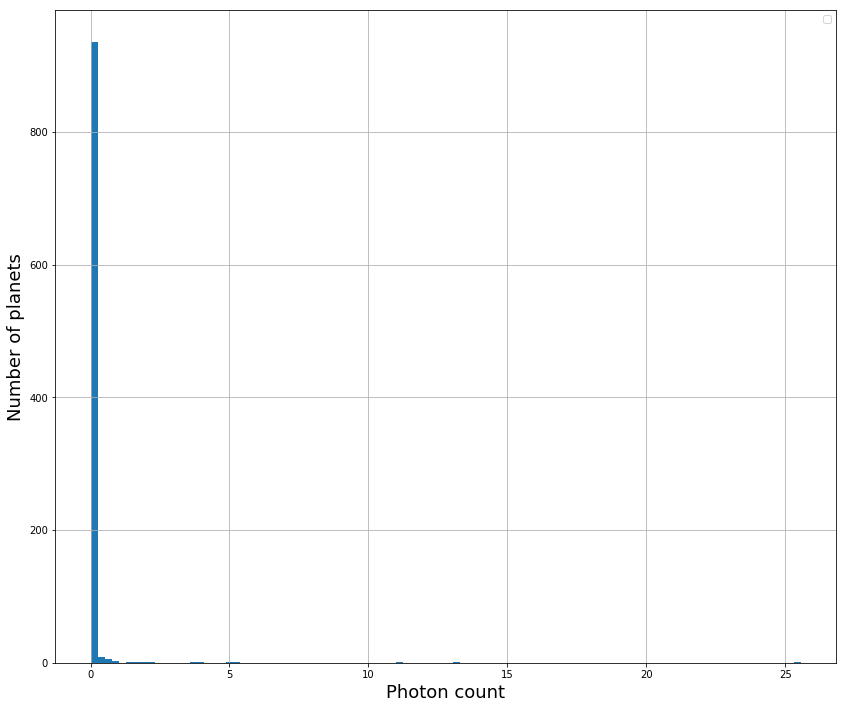

In [19]:
plt.figure(figsize = (14,12))
plt.hist(test.photons_1000W, bins = 100)
plt.xlabel("Photon count", fontsize = 18)
plt.ylabel("Number of planets", fontsize = 18)
#plt.xticks(np.linspace(0,10,11), np.linspace(0,10,11))
plt.grid()
plt.legend()

In [20]:
max(test.photons_1000W)

25.562908456327

In [21]:
np.linspace(0,10,11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [22]:
c = 299792458.
1E+6/2*(10*1E-6)**2/c*1E+26

16678204759907.6

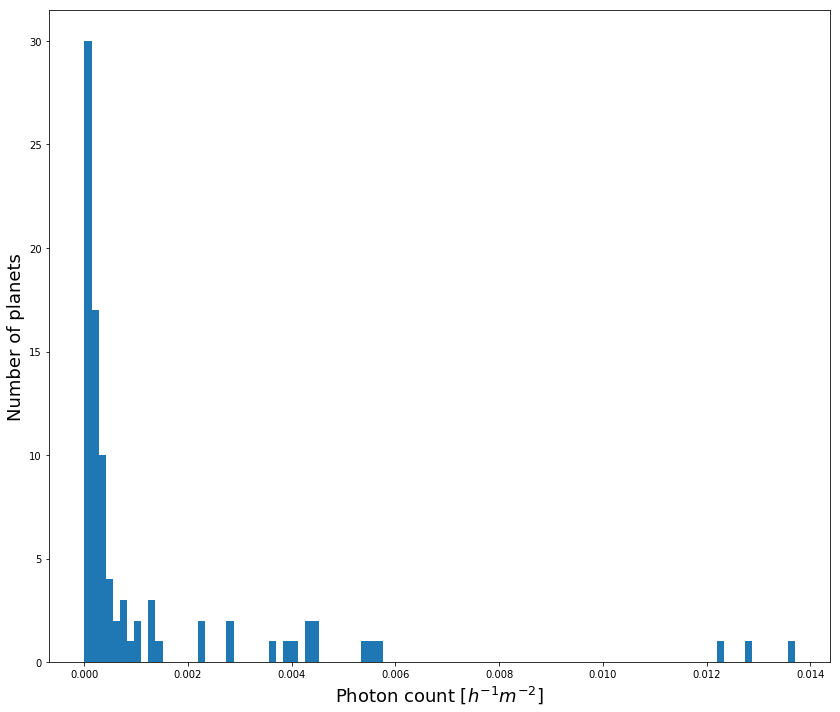

In [23]:
dist_mask_up = test.sdist < 11
dist_mask_down = test.sdist > 9
r_mask_down = test.Rp > 0.5
r_mask_up = test.Rp < 1.65
iwa_mask = test.ang_sep > 5E-3
owa_mask = test.ang_sep < 1
max_flux_mask = test.F_inc <= 1.75 # Fixed HZ
min_flux_mask = test.F_inc >= 0.37
remove_too_big = test.photons_1000W*3600 < 3000
hab_mask =  r_mask_down & r_mask_up & iwa_mask & owa_mask & max_flux_mask & min_flux_mask & remove_too_big
plt.figure(figsize = (14,12))

plt.xlabel("Photon count $[h^{-1} m^{-2}]$", fontsize = 18)
plt.ylabel("Number of planets", fontsize = 18)
plt.hist(test.photons_1000W[hab_mask], bins = 100)
plt.show()

In [25]:
def bb_therm_p_photons(planet,lam):
    """
    Computes planet thermal blackbody flux (in photons per second per square meter per
    micron)
    """

    # Check parameters
    if (isinstance(lam, np.ndarray) == False):
        raise TypeError('lam must be of type numpy.ndarray')

    # Define constants
    h = 6.62607004E-34
    c = 299792458.
    kB = 1.38064852E-23
    Rearth = 6371000.
    pc = 3.0856776E+16
    mask = 457
    #planet.sdist[mask] = 10.
    #planet.Rp[mask] = 2.
    #planet.Tp[mask] = 280.
    return 	1E-6*(2.*np.pi*c/(lam*1E-6)**4./(np.exp(h*c/(lam*1E-6*kB*planet.Tp[mask]))-1.)*((planet.Rp[mask]*Rearth)/(planet.sdist[mask]*pc))**2.)

def bb_therm_p_photons_filter(planet,lam, trans):
    """
    Computes planet thermal blackbody flux (in photons per second per square meter per
    micron)
    """

    # Check parameters
    if (isinstance(lam, np.ndarray) == False):
        raise TypeError('lam must be of type numpy.ndarray')

    return bb_therm_p_photons(planet, lam) * trans
def apply_resolution(photon_flux, nodes, resolution, lambda_eff, w_eff):
    delta_lambda = lambda_eff/resolution
    lam_max = lambda_eff + 1.5*w_eff
    lam_min = lambda_eff - 1.5*w_eff
    x_vals = np.round(np.linspace(lam_min, lam_max, num = (lam_max - lam_min)/delta_lambda + 1 ), decimals = 3)
    points = np.zeros(len(x_vals) -1)
    for i in range(len(x_vals) -1):
        mask_res = np.logical_and(nodes >= x_vals[i], nodes < x_vals[i+1])
        points[i] = si.simps(photon_flux[mask_res], nodes[mask_res])
        #points[i] = np.trapz(photon_flux[mask_res], x = nodes[mask_res])
        #print(points[i])
    x_plot = np.zeros(len(points))
    x_plot = (x_vals[1:] + x_vals[0:-1])/2.
   # print(x_vals)
    #print(x_plot)
    return x_plot, points

def compute_new_range(old_nodes, resolution, lambda_eff, w_eff):
    delta_lambda = lambda_eff/resolution
    lam_max = lambda_eff + 1.5*w_eff
    lam_min = lambda_eff - 1.5*w_eff
    x_vals = np.round(np.linspace(lam_min, lam_max, num = (lam_max - lam_min)/delta_lambda + 1 ), decimals = 3)
    return x_vals
def photons_per_bin(x_vals, photon_flux):
    cum_int = si.cumtrapz(photon_flux, x_vals, initial=0)
    vals = cum_int[1:] - cum_int[0:-1]
    x_plot = np.zeros(len(vals))
    x_plot = (x_vals[1:] + x_vals[0:-1])/2.
    return x_plot, vals
lsp = np.linspace(0.1,40.,10000)
filter2 = np.load('data/F1000W.npy', allow_pickle=True, encoding="bytes")
try_one = bb_therm_p_photons(test, filter2[0])*3600.
try_second = bb_therm_p_photons_filter(test, filter2[0], filter2[1])*3600
x_vals_25, photons_25 = apply_resolution(try_one, filter2[0], 25., filter2[2], filter2[3])


x_spec_25 = compute_new_range(filter2[0], 25., filter2[2], filter2[3])
photons_25_spec = spectres.spectres(x_spec_25, filter2[0], try_one)
n_x_vals_25, n_photons_25 = photons_per_bin(x_spec_25, photons_25_spec)


#print(filter2[0])
#print(x_spec_25)
#x_vals_100, photons_100 = apply_resolution(try_one, filter2[0], 100., filter2[2], filter2[3])
#x_vals_10, photons_10 = apply_resolution(try_one, filter2[0], 10., filter2[2], filter2[3])


/home/emilio/.local/lib/python2.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/emilio/.local/lib/python2.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


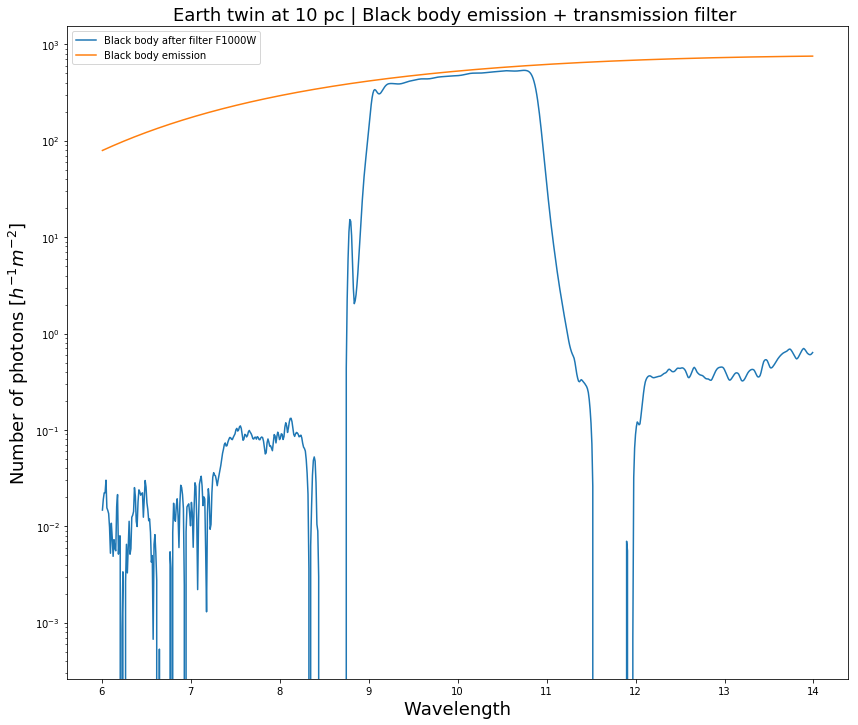

In [41]:
plt.figure(figsize = (14,12))
plt.xlabel("Wavelength", fontsize = 18)
plt.ylabel("Number of photons [$h^{-1} m^{-2}$]", fontsize = 18)
plt.plot(filter2[0], try_second, label = "Black body after filter F1000W")
plt.title("Earth twin at 10 pc | Black body emission + transmission filter ", fontsize = 18)
plt.plot(filter2[0], try_one, label = "Black body emission")
#plt.plot(filter2[0], photon_flux, label = "Black body emission after absolute transmission")
#plt.plot(filter2[0], try_second, label = "Black body emission")
#plt.plot(x_vals_25, photons_25, label = "Photon count for a resolution of 25")
#plt.plot(n_x_vals_25, n_photons_25, label = "Photon count for a resolution of 25 - SPECTRES")
#plt.plot(x_vals_100, photons_100, label = "Photon count for a resolution of 100")
#plt.plot(x_vals_10, photons_10, label = "Photon count for a resolution of 10")
#plt.plot(filter2[0], filter2[1], label = "Filter")
#plt.axvline(x_vals_100[40], ls = "--", color = "k")
plt.legend()
plt.yscale("log")
#plt.yticks([1E-2, 1E-1, 1E0, 1E1, 1E2, 1E3], [1E-2, 1E-1, 1E0, 1E1, 1E2, 1E3])
plt.savefig("photons_earthtwin.png")
plt.show()

In [31]:
si.simps(try_second*24*math.pi*3.5*3.5, filter2[0])

812879.0583728798

In [33]:
test.photons_1000W[457]*3600*24*math.pi*3.5*3.5

1352.4965331482786

In [35]:
812879/1352

601

In [40]:
test.a[457]

0.17923

In [39]:
trans[28,2]

0.03379

In [16]:
h = 6.62607004E-34
c = 299792458.
kB = 1.38064852E-23
lambda_max = h*c/(3.9207 * kB * test.Tp[25])
print(lambda_max * 1E6)

3.1977167918845804


In [15]:
np.linspace(0.1,40,10000)[np.argmax(try_one)]

2.7855385538553854

In [24]:
f = irp.interp1d(filter2[0], try_second*3600)

In [51]:
wv_step = 2./5.
start = min(filter2[0])
stop = max(filter2[0])
new_x = np.linspace(8, 12, num = (12-8)/wv_step + 1 )

In [53]:
new_y = f(new_x)

In [73]:
mask_res = np.logical_and(filter2[0] >= new_x[4], filter2[0] <= new_x[5])

In [74]:
si.simps(try_second[mask_res], filter2[0][mask_res])

692.8780953710232

In [19]:
dat = np.loadtxt("data/METIS_Mp.dat")

In [20]:
dat[:,0][np.argmax(dat[:,1])]

4.8504

In [24]:
with open("test_METIS_METIS.txt", "r") as f:
    lines = (line for line in f)
    new_fluxes = np.loadtxt(lines[1:])

TypeError: 'generator' object is not subscriptable

## Adding the absolute transmission filter to ti

In [15]:
trans = np.loadtxt("data/transmission_sum_full_rotation.dat", skiprows=1)

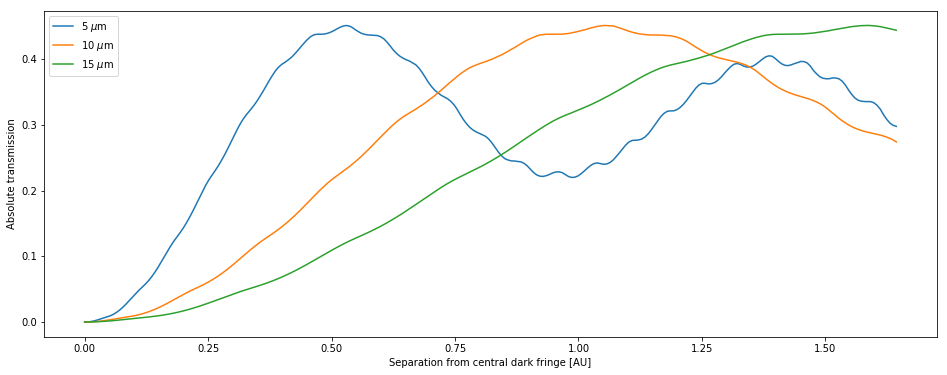

In [13]:
plt.figure(figsize = (16,6))
plt.plot(trans[:,0], trans[:,1], label = "5 $\mu$m")
plt.plot(trans[:,0], trans[:,2], label = "10 $\mu$m")
plt.plot(trans[:,0], trans[:,3], label = "15 $\mu$m")
plt.xlabel("Separation from central dark fringe [AU]")
plt.ylabel("Absolute transmission")
plt.legend()

In [49]:
wavelengths = np.linspace(4,18, 14001)
real_trans = np.ones((256,len(wavelengths)+1))
for it in range (len(real_trans[0])):
    if(it == 0):
        real_trans[:,it] = trans[:,0]
    else:
        real_trans[:,it] = trans[:,2]

In [48]:
def find_nearest(array, value):
    #Returns the index of the value in array that is nearest to value
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [62]:
import scipy.interpolate as scitrp
photon_flux = try_one
rp = 0.51 # AU
nodes = filter2[0]
for wave in nodes:
    curve_idx = find_nearest(wavelengths, wave) + 1
    curve = real_trans[:,curve_idx]
    if rp not in real_trans[:,0]:
        interpolated_curve = scitrp.interp1d(trans[:,0], curve)
        transmission = interpolated_curve(rp)
    else:
        transmission = curve[np.where(real_trans[:,0] == rp)]
photon_flux = photon_flux * transmission

In [64]:
transmission

array(0.22202693)

In [38]:
trans[28,2]

0.03379